In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib


In [3]:
# 1. Load the Dataset
df = pd.read_csv('/home/hansboe/Desktop/poverty ml project/tanzania_poverty_model_data.csv')

In [4]:
# 2. Data Preprocessing & Encoding
# We use manual mapping to ensure consistency between training and the app
edu_map = {'No education': 0, 'Primary': 1, 'Secondary': 2, 'Tertiary': 3}
emp_map = {'Unemployed': 0, 'Agriculture': 1, 'Self-employed': 2, 'Wage employment': 3}
house_map = {'No': 0, 'Yes': 1}
ur_map = {'Rural': 0, 'Urban': 1}

df['education_head'] = df['education_head'].map(edu_map)
df['employment_status'] = df['employment_status'].map(emp_map)
df['own_house'] = df['own_house'].map(house_map)
df['urban_rural'] = df['urban_rural'].map(ur_map)

In [5]:
# Define Features and Target
X = df.drop('poverty_risk_level', axis=1)
y = df['poverty_risk_level']

In [6]:
# Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# 3. Model Training - Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

In [9]:
# 4. Model Training - Decision Tree
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)

In [10]:
# 5. Model Evaluation & Comparison
def evaluate(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    # Accuracy for classification-like regression (rounding to nearest risk level)
    acc = np.mean(np.round(y_pred) == y_true) 
    print(f"--- {name} Metrics ---")
    print(f"MSE: {mse:.4f}")
    print(f"R2 Score: {r2:.4f}")
    print(f"Accuracy (Approx): {acc*100:.2f}%\n")
    return r2

lr_r2 = evaluate(y_test, lr_pred, "Linear Regression")
dt_r2 = evaluate(y_test, dt_pred, "Decision Tree")

--- Linear Regression Metrics ---
MSE: 0.4389
R2 Score: 0.7589
Accuracy (Approx): 51.00%

--- Decision Tree Metrics ---
MSE: 0.0400
R2 Score: 0.9780
Accuracy (Approx): 96.00%



In [11]:
# 6. Save the Best Model and Mappings
# Decision Tree usually performs better for this specific ordinal data
best_model = dt_model if dt_r2 > lr_r2 else lr_model
joblib.dump(best_model, 'model.pkl')

# Save mappings so the Streamlit app knows how to encode user input
mappings = {
    'education_head': edu_map,
    'employment_status': emp_map,
    'own_house': house_map,
    'urban_rural': ur_map
}
joblib.dump(mappings, 'mappings.pkl')
print("Model and Mappings saved successfully!")

Model and Mappings saved successfully!


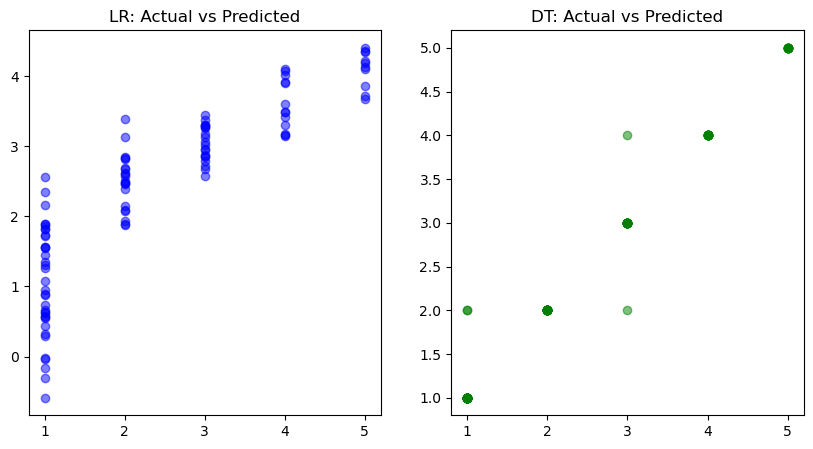

In [12]:
# 7. Visualization
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, lr_pred, color='blue', alpha=0.5)
plt.title('LR: Actual vs Predicted')
plt.subplot(1, 2, 2)
plt.scatter(y_test, dt_pred, color='green', alpha=0.5)
plt.title('DT: Actual vs Predicted')
plt.savefig('results_plot.png')
plt.show()